# Sentiment Classifier for Rotten Tomatoes Movie Reviews

## II. Exploratory Data Analysis

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
#plt.style.use('dark_background')
plt.style.use(style="seaborn")
%matplotlib inline

# Import custom preprocessing functions
import sys
sys.path.insert(0, 'modules/')
from data_preprocessing import *

# NLP
from nltk.tokenize import word_tokenize
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Sentiment Analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

We can load the cleaned data from the previous section.

In [2]:
#df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/final-project/data/rotten_tomatoes/reviews_clean.csv', encoding='utf-8')
df = pd.read_csv('../data/rotten_tomatoes/rotten_tomatoes_critic_reviews.csv', encoding='utf-8')
reviews = pd.read_csv('../data/rotten_tomatoes/reviews_clean.csv', encoding='utf-8')

Let's make sure that the `Text` column values are of type *str* 

In [3]:
reviews['Text'] = reviews['Text'].astype('str')

In [4]:
reviews

Text  Type
0       fantasy adventure fuse greek mythology contemp...     1
1       uma thurman medusa gorgon coiffure writhing sn...     1
2       topnotch cast dazzling special effect tide tee...     1
3       whether audience get behind lightning thief ha...     1
4       really lacking lightning thief genuine sense w...     0
...                                                   ...   ...
949176    rousing reconstruction 1879 battle rorkes drift     1
949177  seen today startling indictment british imperi...     1
949178  rousing visual spectacle prequel cy endfield d...     1
949179  simple twoact story prelude war war former con...     0
949180  ride line pure artifact bygone eraone depicts ...     0

[949181 rows x 2 columns]

Because the dataset is quite large (~950,000 rows), we will take a random sample of 300,000 for analysis.

In [5]:
reviews_300k = reviews.sample(300000, random_state = 777)

In [6]:
reviews_300k.head()

Text  Type
37155       real meat potato proposition satisfying tasty     1
501962  young old jock nerd geek freak everyone able f...     1
144431  strong performance thornton kinnear barely com...     1
795218     entertaining romp succeeds level pure escapism     1
660748  borgesian critique exotic backdrop scoundrel h...     1

Let's save this into a CSV file:

In [6]:
reviews_300k.to_csv("../data/rotten_tomatoes/reviews_300k.csv", index=False)

We can visualize the composition of Fresh (1) vs Rotten (0) ratings through the plot below:

<AxesSubplot:xlabel='Type', ylabel='count'>

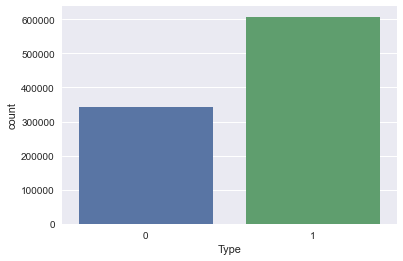

In [7]:
sns.countplot(x='Type', data=reviews)

And for the 300k dataset, we could also find a similar composition.

<AxesSubplot:xlabel='Type', ylabel='count'>

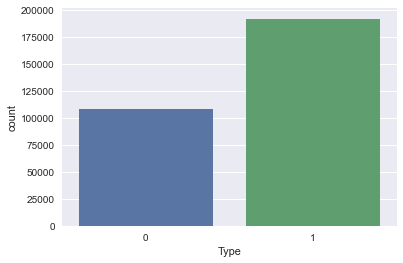

In [8]:
sns.countplot(x='Type', data=reviews_300k)

A plot of the distribution of review lengths would help us determine a max length of words per review for our analysis.

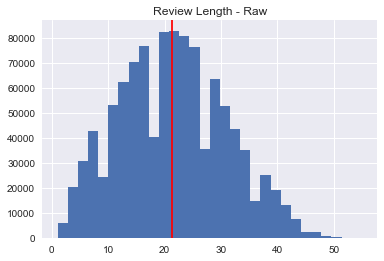

In [14]:
df_review_word_count = []

# Populate the list with the lengths of the sentences
for review in df.dropna(subset = ['review_content'])['review_content'].values:
      df_review_word_count.append(len(review.split()))

length_df = pd.DataFrame({'review_content':df_review_word_count})

length_df.hist(bins = 30)
plt.title('Review Length - Raw')
plt.axvline(length_df['review_content'].mean(), c='red', label='Mean')
plt.savefig('../output/img/review-lengths-raw.jpg')
plt.show()

However, let's take a look at the lengths for the cleaned reviews.

Distribution of Review Length for Full Dataset:

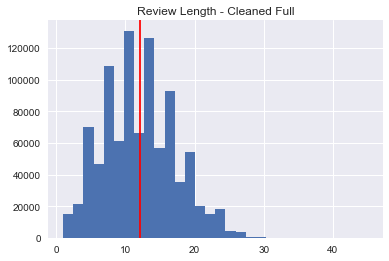

In [15]:
clean_review_word_count = []

# populate the lists with sentence lengths
for review in reviews['Text'].values:
      clean_review_word_count.append(len(review.split()))

clean_length_df = pd.DataFrame({'Text':clean_review_word_count})

clean_length_df.hist(bins = 30)
plt.title('Review Length - Cleaned Full')
plt.axvline(clean_length_df['Text'].mean(), c='red', label='Mean')
plt.savefig('../output/img/review-lengths-clean-full.jpg')
plt.show()

Distribution of Review Length for the 300k Dataset

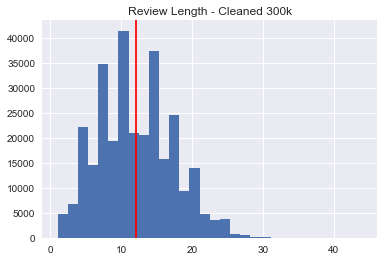

In [16]:
clean_review_300k_word_count = []

# populate the lists with sentence lengths
for review in reviews_300k['Text'].values:
      clean_review_300k_word_count.append(len(review.split()))

clean_300k_length_df = pd.DataFrame({'Text':clean_review_300k_word_count})

clean_300k_length_df.hist(bins = 30)
plt.title('Review Length - Cleaned 300k')
plt.axvline(clean_300k_length_df['Text'].mean(), c='red', label='Mean')

plt.show()

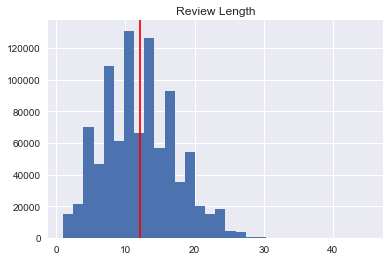

In [17]:
clean_review_word_count = []

# populate the lists with sentence lengths
for review in reviews['Text'].values:
      clean_review_word_count.append(len(review.split()))

clean_length_df = pd.DataFrame({'Text':clean_review_word_count})

clean_length_df.hist(bins = 30)
plt.title('Review Length')
plt.axvline(clean_length_df['Text'].mean(), c='red', label='Mean')
plt.savefig('../output/img/review-lengths-300k.jpg')
plt.show()

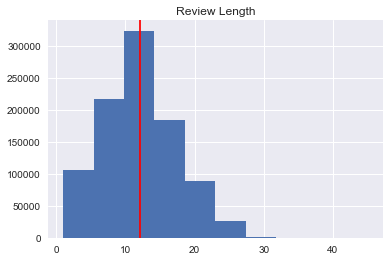

In [12]:
clean_review_word_count = []

# populate the lists with sentence lengths
for review in reviews['Text'].values:
      clean_review_word_count.append(len(review.split()))

clean_length_df = pd.DataFrame({'Text':clean_review_word_count})

clean_length_df.hist()
plt.title('Review Length')
plt.axvline(clean_length_df['Text'].mean(), c='red', label='Mean')

plt.show()

It seems like 30 could be a good number for max length of words per review for our analysis. But based on my observation for years of reading reviews in Rotten Tomatoes, reviews could take longer, so let's set it a little bit higher to 50.

In [13]:
reviews_fresh = reviews_300k[reviews_300k['Type'] == 1]
reviews_rotten = reviews_300k[reviews_300k['Type'] == 0]

In [18]:
reviews_fresh.head()

Text  Type
37155       real meat potato proposition satisfying tasty     1
501962  young old jock nerd geek freak everyone able f...     1
144431  strong performance thornton kinnear barely com...     1
795218     entertaining romp succeeds level pure escapism     1
660748  borgesian critique exotic backdrop scoundrel h...     1

In [19]:
reviews_rotten.head()

Text  Type
664258  extremely dull every sense even devoted fan fi...     0
245516  crossing heart umpteen place head stuffed dram...     0
841531  one stronger ensemble movie year drama offer c...     0
613931       somebody chewed head would least forget mess     0
95810   familyfriendly yet frustrating psychedelic sel...     0

In [20]:
reviews_fresh_str = reviews_fresh['Text'].str.cat(sep=' ')
reviews_rotten_str = reviews_rotten['Text'].str.cat(sep=' ')

In [21]:
wordcloud_fresh = WordCloud(background_color='white').generate(reviews_fresh_str)
wordcloud_rotten = WordCloud(background_color='white').generate(reviews_rotten_str)

### Word Clouds

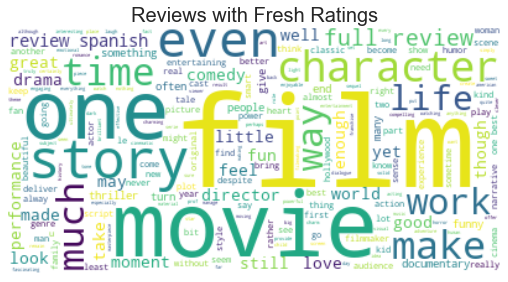

In [26]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,1,1)
ax1.imshow(wordcloud_fresh, interpolation='bilinear')
ax1.axis('off')
ax1.set_title('Reviews with Fresh Ratings', fontsize=20)
plt.savefig("../output/img/fresh_wordcloud.png", format="png")

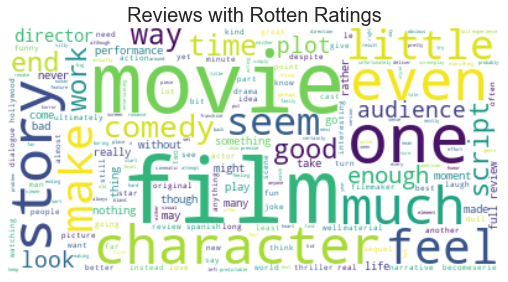

In [27]:
fig = plt.figure(figsize=(10,10))
ax2 = fig.add_subplot(2,1,2)
ax2.imshow(wordcloud_rotten, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Reviews with Rotten Ratings', fontsize=20)
plt.savefig("../output/img/rotten_wordcloud.png", format="png")

Text(0.5, 1.0, 'Reviews with Rotten Ratings')

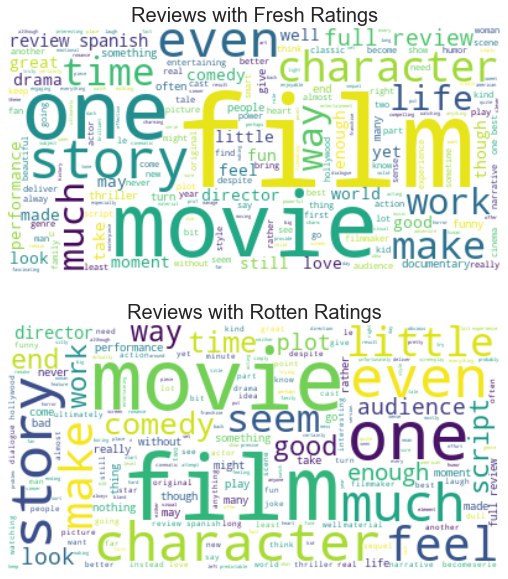

In [28]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,1,1)
ax1.imshow(wordcloud_fresh, interpolation='bilinear')
ax1.axis('off')
ax1.set_title('Reviews with Fresh Ratings', fontsize=20)
ax2 = fig.add_subplot(2,1,2)
ax2.imshow(wordcloud_rotten, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Reviews with Rotten Ratings', fontsize=20)

Let’s visualize the words in "Fresh" reviews (1) with the help of a word cloud and use a red tomato as its mask for aesthetics.

#### Word Clouds for Fresh Reviews (with mask)

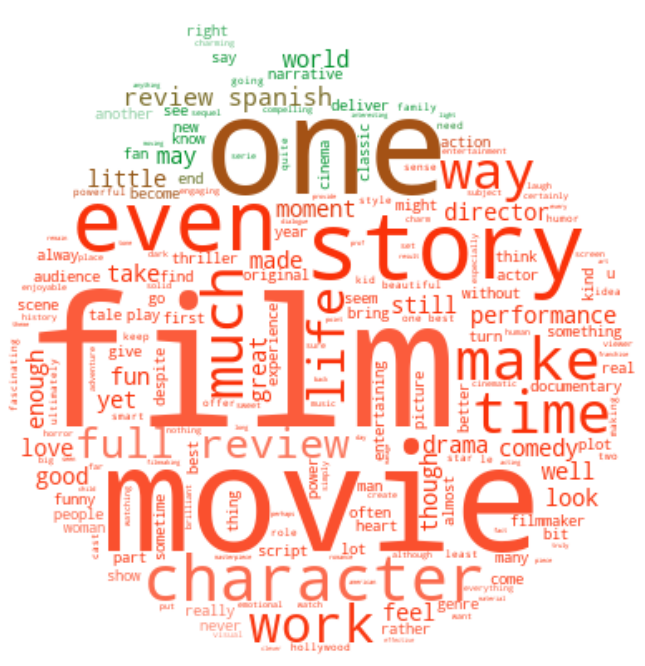

In [36]:
# Generate a word cloud image
#mask = np.array(Image.open('../output/img/red_tomato_mask_colored.png'))
mask = np.array(Image.open('../output/img/red-tomato.png'))
#wordcloud_tomato = WordCloud(stopwords=STOPWORDS, background_color="white", mode="RGBA", max_words=1000, mask=mask).generate(' '.join(str(review) for review in reviews[reviews['Type']==1]['Text']))
wordcloud_tomato_fresh = WordCloud(stopwords=STOPWORDS, background_color="white", max_words=200, mask=mask).generate(reviews_fresh_str)

# Create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[12,12])
plt.imshow(wordcloud_tomato_fresh.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

# store to file
plt.savefig("../output/img/fresh_tomato_wordcloud_200.png", format="png")

plt.show()

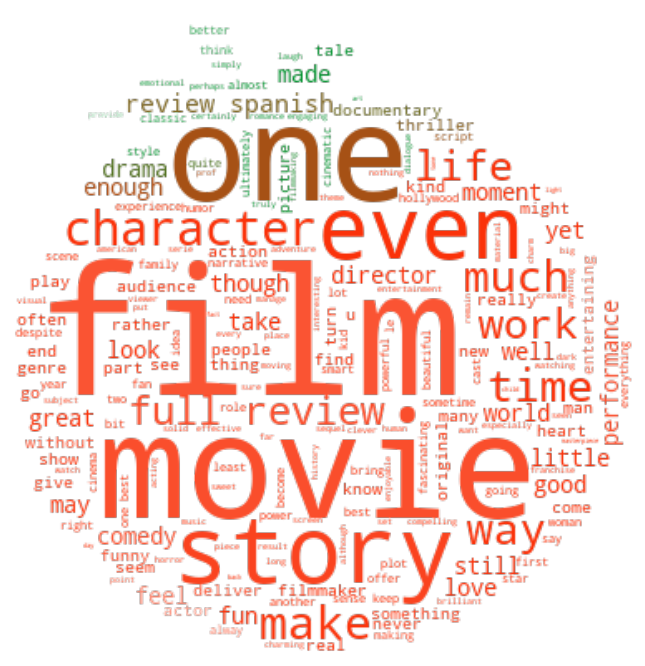

In [52]:
# Generate a word cloud image
#mask = np.array(Image.open('../output/img/red_tomato_mask_colored.png'))
mask = np.array(Image.open('../output/img/red-tomato.png'))
#wordcloud_tomato = WordCloud(stopwords=STOPWORDS, background_color="white", mode="RGBA", max_words=1000, mask=mask).generate(' '.join(str(review) for review in reviews[reviews['Type']==1]['Text']))
wordcloud_tomato_fresh = WordCloud(stopwords=STOPWORDS, mode='RGBA', background_color=None, max_words=200, mask=mask).generate(reviews_fresh_str)

# Create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[12,12])
plt.imshow(wordcloud_tomato_fresh.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

# store to file
plt.savefig("../output/img/fresh_tomato_wordcloud_200_transparent.png", format="png")

plt.show()

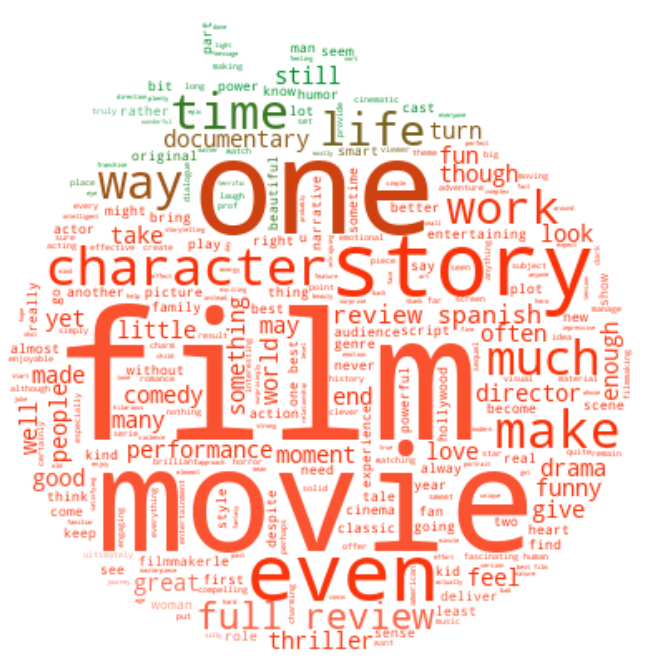

In [38]:
# Generate a word cloud image
#mask = np.array(Image.open('../output/img/red_tomato_mask_colored.png'))
mask = np.array(Image.open('../output/img/red-tomato.png'))
#wordcloud_tomato = WordCloud(stopwords=STOPWORDS, background_color="white", mode="RGBA", max_words=1000, mask=mask).generate(' '.join(str(review) for review in reviews[reviews['Type']==1]['Text']))
wordcloud_tomato_fresh = WordCloud(stopwords=STOPWORDS, background_color="white", max_words=1000, mask=mask).generate(reviews_fresh_str)

# Create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[12,12])
plt.imshow(wordcloud_tomato_fresh.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

# store to file
plt.savefig("../output/img/fresh_tomato_wordcloud_1000.png", format="png")

plt.show()

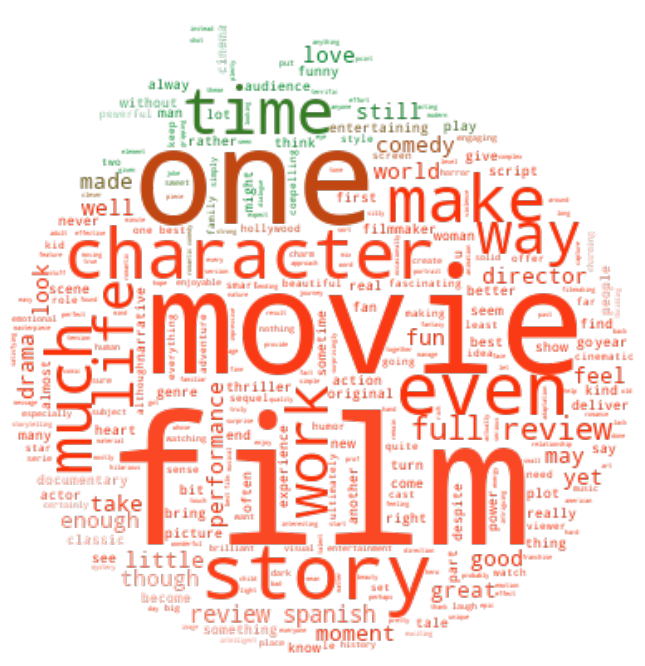

In [51]:
# Generate a word cloud image
#mask = np.array(Image.open('../output/img/red_tomato_mask_colored.png'))
mask = np.array(Image.open('../output/img/red-tomato.png'))
#wordcloud_tomato = WordCloud(stopwords=STOPWORDS, background_color="white", mode="RGBA", max_words=1000, mask=mask).generate(' '.join(str(review) for review in reviews[reviews['Type']==1]['Text']))
wordcloud_tomato_fresh = WordCloud(stopwords=STOPWORDS, mode='RGBA', background_color=None, max_words=1000, mask=mask).generate(reviews_fresh_str)

# Create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[12,12])
plt.imshow(wordcloud_tomato_fresh.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

# store to file
plt.savefig("../output/img/fresh_tomato_wordcloud_1000_transparent.png", format="png")

plt.show()

#### Word Clouds for Rotten Reviews (with mask)

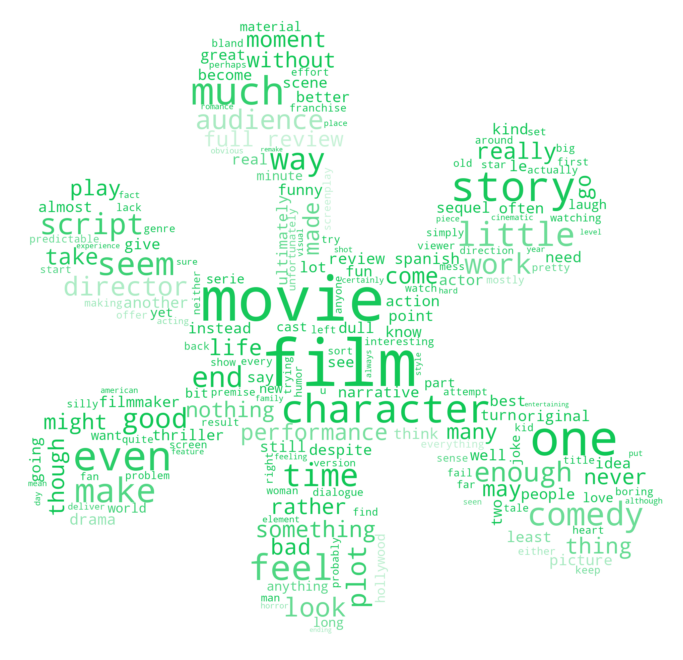

In [56]:
# Generate a word cloud image
mask_rotten = np.array(Image.open('../output/img/green-splat.png'))
#wordcloud_tomato = WordCloud(stopwords=STOPWORDS, background_color="white", mode="RGBA", max_words=1000, mask=mask).generate(' '.join(str(review) for review in reviews[reviews['Type']==1]['Text']))
wordcloud_tomato_rotten = WordCloud(stopwords=STOPWORDS, background_color="white", max_words=200, mask=mask_rotten).generate(reviews_rotten_str)

# Create coloring from image
image_colors = ImageColorGenerator(mask_rotten)
plt.figure(figsize=[12,12])
plt.imshow(wordcloud_tomato_rotten.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

# store to file
plt.savefig("../output/img/green_splat_wordcloud_200.png", format="png")

plt.show()

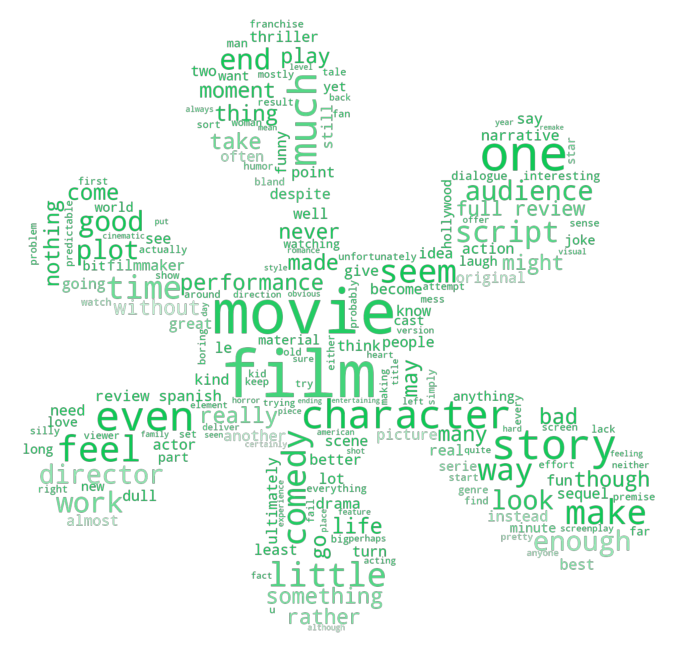

In [57]:
# Generate a word cloud image
mask_rotten = np.array(Image.open('../output/img/green-splat.png'))
#wordcloud_tomato = WordCloud(stopwords=STOPWORDS, background_color="white", mode="RGBA", max_words=1000, mask=mask).generate(' '.join(str(review) for review in reviews[reviews['Type']==1]['Text']))
wordcloud_tomato_rotten = WordCloud(stopwords=STOPWORDS, mode='RGBA', background_color=None, max_words=200, mask=mask_rotten).generate(reviews_rotten_str)

# Create coloring from image
image_colors = ImageColorGenerator(mask_rotten)
plt.figure(figsize=[12,12])
plt.imshow(wordcloud_tomato_rotten.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

# store to file
plt.savefig("../output/img/green_splat_wordcloud_200_transparent.png", format="png")

plt.show()

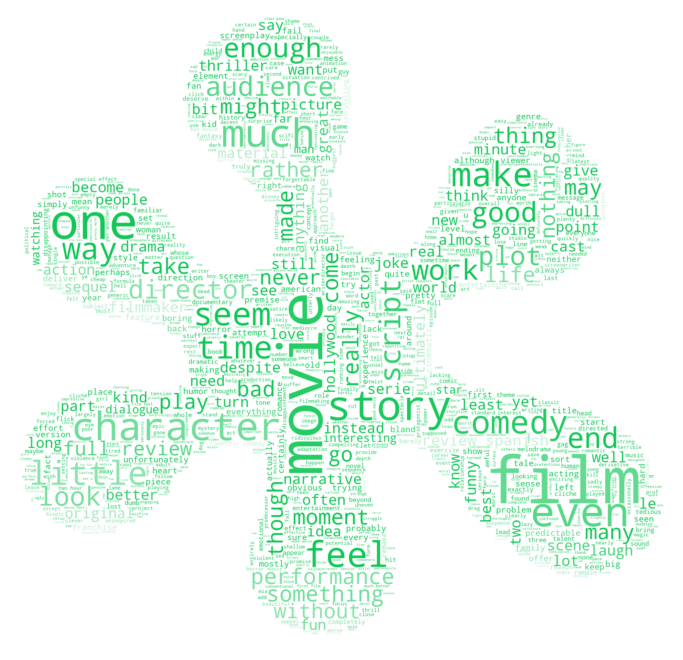

In [58]:
# Generate a word cloud image
mask_rotten = np.array(Image.open('../output/img/green-splat.png'))
#wordcloud_tomato = WordCloud(stopwords=STOPWORDS, background_color="white", mode="RGBA", max_words=1000, mask=mask).generate(' '.join(str(review) for review in reviews[reviews['Type']==1]['Text']))
wordcloud_tomato_rotten = WordCloud(stopwords=STOPWORDS, background_color="white", max_words=1000, mask=mask_rotten).generate(reviews_rotten_str)

# Create coloring from image
image_colors = ImageColorGenerator(mask_rotten)
plt.figure(figsize=[12,12])
plt.imshow(wordcloud_tomato_rotten.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

# store to file
plt.savefig("../output/img/green_splat_wordcloud_1000.png", format="png")

plt.show()

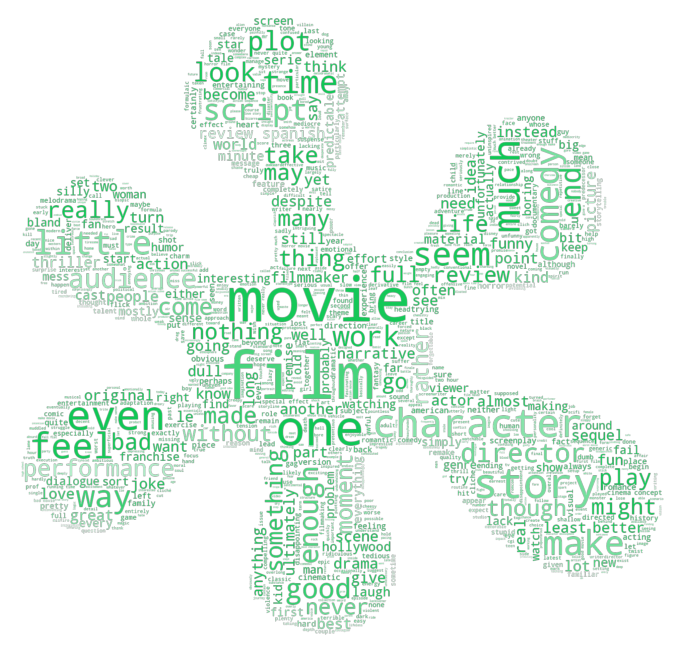

In [59]:
# Generate a word cloud image
mask_rotten = np.array(Image.open('../output/img/green-splat.png'))
#wordcloud_tomato = WordCloud(stopwords=STOPWORDS, background_color="white", mode="RGBA", max_words=1000, mask=mask).generate(' '.join(str(review) for review in reviews[reviews['Type']==1]['Text']))
wordcloud_tomato_rotten = WordCloud(stopwords=STOPWORDS, mode='RGBA', background_color=None, max_words=1000, mask=mask_rotten).generate(reviews_rotten_str)

# Create coloring from image
image_colors = ImageColorGenerator(mask_rotten)
plt.figure(figsize=[12,12])
plt.imshow(wordcloud_tomato_rotten.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

# store to file
plt.savefig("../output/img/green_splat_wordcloud_1000_transparent.png", format="png")

plt.show()

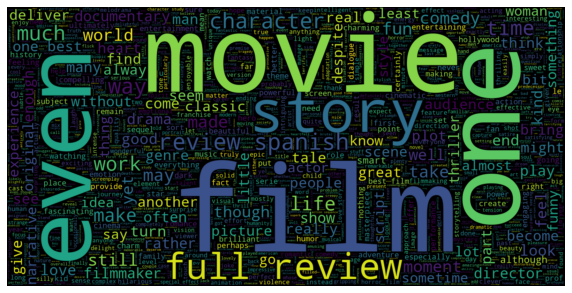

In [36]:
plt.figure(figsize=(10,20))
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=STOPWORDS).generate(' '.join(str(review) for review in reviews[reviews['Type']==1]['Text']))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()